In [1]:
# automaticlly updates imported methods when they change
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
sys.path.append(str(Path().cwd().parent))

# Jitter issues
After closely inspecting panchromatic (as well as filtered) pixels along consequent frames, there seems to be some weired inconsistent trend (jitter) in the obtained grey levels (with a dynamic range of ~100 grey-levels).

The jitter issue is problematic since it affects the quality of the camera's modeling and calibration, and since an acquisition of a static scene can result in significant unpredictable bias differences of upto ~100 grey levels.

below is an example of the jitter in grey levels across 100K consecutively acquired frame (equivalent to ~30 minutes), at different random pixel locations:

Loading and displaying jitter effect: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.90s/it]


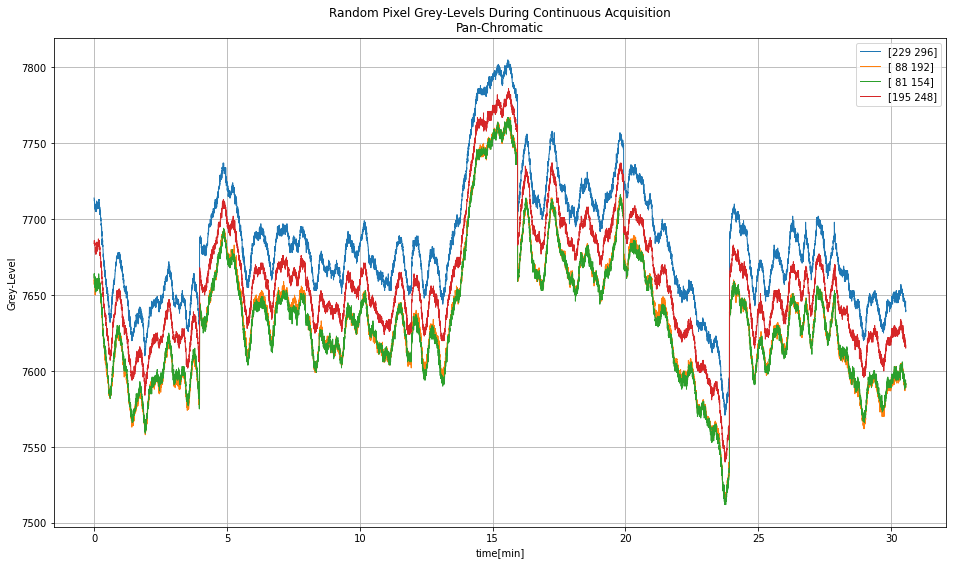

In [3]:
from plots import plotGlAcrossFrames
from tools import get_temperature_and_wavelength
from pathlib import Path
from tqdm import tqdm
import numpy as np
import pandas as pd

path_to_files = Path.cwd()
while not (path_to_files / "rawData").is_dir():
    path_to_files = path_to_files.parent
path_to_files = path_to_files / "rawData" / 'jitter'
path_to_files = list(path_to_files.glob('*.npy'))

for path in tqdm(path_to_files, desc="Loading and displaying jitter effect"):
    path, temperature_blackbody, filter_name = get_temperature_and_wavelength(path)
    grey_levels = plotGlAcrossFrames(np.load(path), wavelength=int(path.stem.split('_')[-1]))
    temperatures = pd.read_csv(path.with_suffix('.csv'))


T-Linear effect

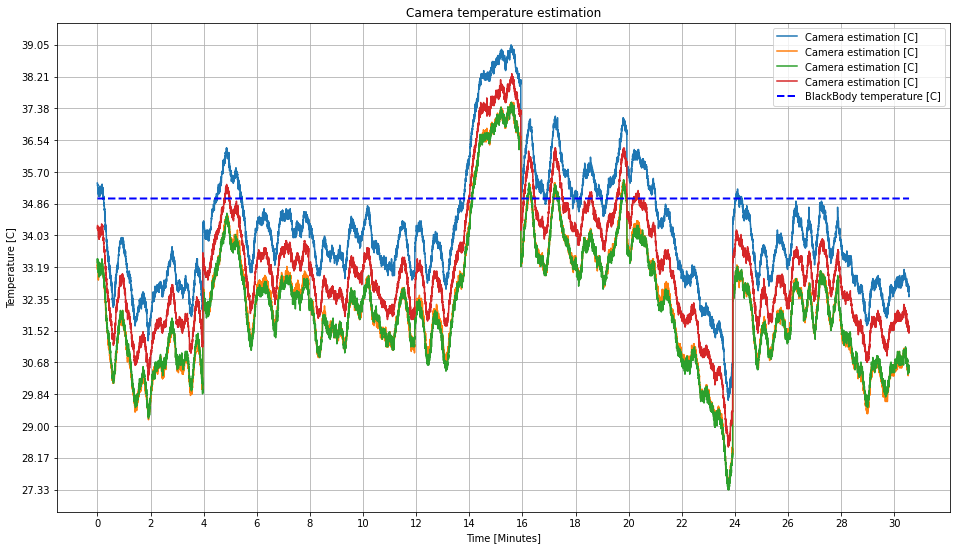

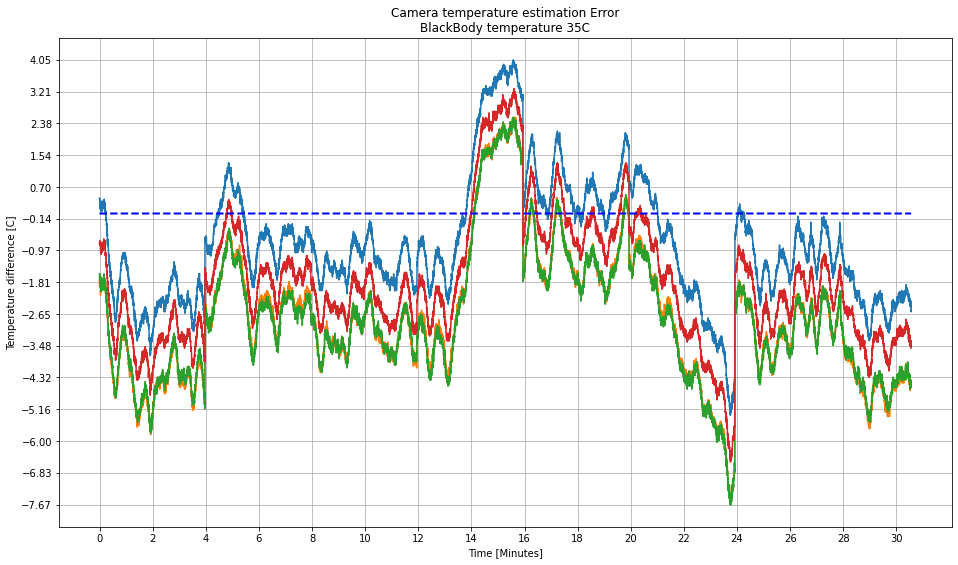

In [4]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from tools import get_temperature_and_wavelength

x_time = np.array(temperatures.index) / 3600
t = 0.04*grey_levels - 273.15

plt.figure(figsize=(16, 9))
plt.plot(x_time, t, label='Camera estimation [C]')
plt.plot(x_time, np.ones_like(x_time) * temperature_blackbody, '--b', linewidth=2, label='BlackBody temperature [C]')
plt.legend()
plt.title(f'Camera temperature estimation')
plt.xlabel('Time [Minutes]')
plt.ylabel('Temperature [C]')
plt.yticks(np.linspace(t.min(), t.max(), 15))
plt.xticks(np.arange(x_time.min(), x_time.max(), 2))
plt.grid()
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(x_time, t - temperature_blackbody)
plt.plot(x_time, np.zeros_like(x_time), '--b', linewidth=2)
plt.title(f'Camera temperature estimation Error\nBlackBody temperature {temperature_blackbody}C')
plt.xlabel('Time [Minutes]')
plt.ylabel('Temperature difference [C]')
plt.yticks(np.linspace((t - temperature_blackbody).min(), (t - temperature_blackbody).max(), 15))
plt.xticks(np.arange(x_time.min(), x_time.max(), 2))
plt.grid()
plt.show()


## Correlation To Housing/FPA temperature:

CSV containts the following values: FPA temperature, Housing temperature, Filter wavelength nm


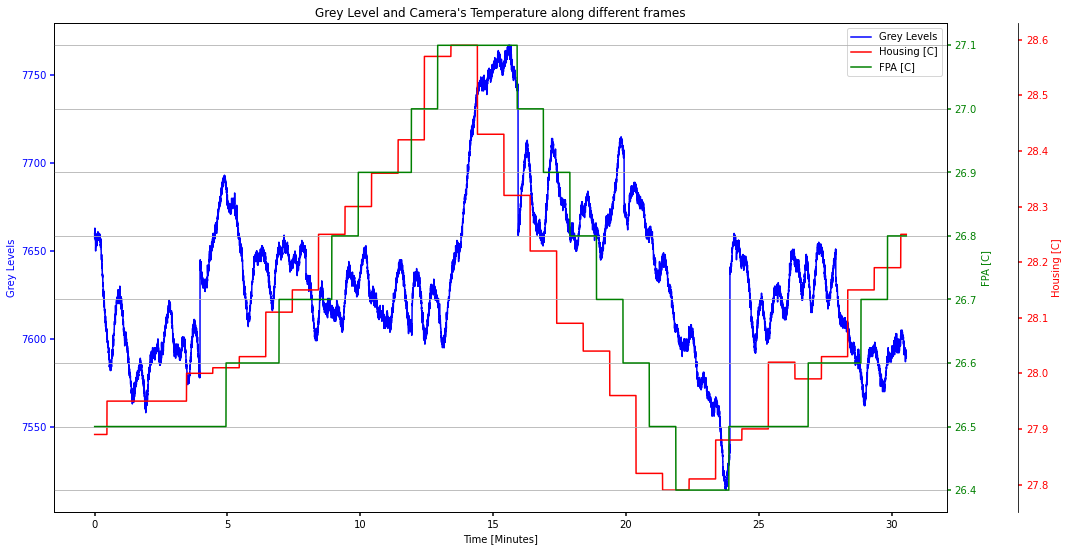

In [5]:
import matplotlib.pyplot as plt

stmt = f'{temperatures.columns[1]}'
for col in temperatures.columns[2:]:
    stmt += f', {col}'
print(f'CSV containts the following values: {stmt}')

x_time = np.array(temperatures.index) / 3600
housing = temperatures["Housing temperature"] / 100
fpa = temperatures["FPA temperature"] / 100
gl = grey_levels[:, 1]

fig, ax = plt.subplots(figsize=(16, 9))


twin_housing = ax.twinx()
twin_fpa = ax.twinx()

# Offset the right spine of twin_housing.  The ticks and label have already been
# placed on the right by twinx above.
twin_housing.spines.right.set_position(("axes", 1.08))

p1, = ax.plot(x_time, gl, "b-", label="Grey Levels")
p2, = twin_housing.plot(x_time, housing, "r-", label="Housing [C]")
p3, = twin_fpa.plot(x_time, fpa, "g-", label="FPA [C]")

ax.set_ylabel("Grey Levels")
ax.set_xlabel("Time [Minutes]")
twin_housing.set_ylabel('Housing [C]')
twin_fpa.set_ylabel('FPA [C]')

ax.yaxis.label.set_color(p1.get_color())
twin_housing.yaxis.label.set_color(p2.get_color())
twin_fpa.yaxis.label.set_color(p3.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
twin_housing.tick_params(axis='y', colors=p2.get_color(), **tkw)
twin_fpa.tick_params(axis='y', colors=p3.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

ax.legend(handles=[p1, p2, p3])

ax.set_title("Grey Level and Camera's Temperature along different frames")
plt.grid()
plt.show()

There appears to be some negative correlation between temperature and grey-levels.

Let's see if a linear regression can be used to de-trend the flactuations in grey-levels to some extent:

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Correlation Coefficients:


array([[1.        , 0.55290761],
       [0.55290761, 1.        ]])

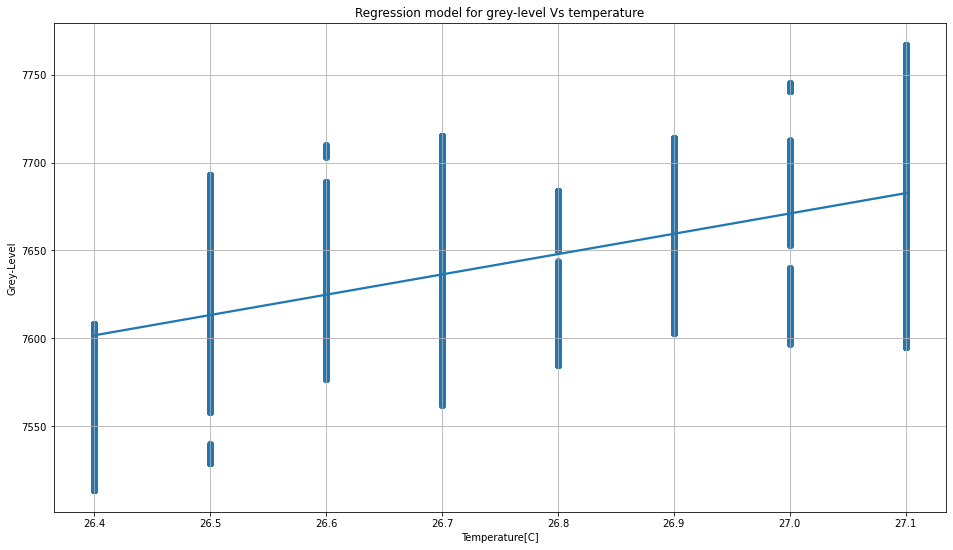

In [7]:
# first, let's display a regression model for an arbitrary pixel:
from sklearn.linear_model import LinearRegression
from IPython.display import display, Latex
import seaborn as sns

x, y = fpa.values[:, None], gl[:, None]
lr = LinearRegression().fit(x, y)
plt.figure(figsize=(16, 9))
res = sns.regplot(x=x, y=y, fit_reg=True)
plt.title(f"Regression model for grey-level Vs temperature")
plt.xlabel("Temperature[C]")
plt.ylabel("Grey-Level")
plt.grid()

display(Latex(
    fr"Regression result: $GL = {lr.coef_.squeeze():.3f} \times T +{lr.intercept_.squeeze():.3f}$"))
display(Latex(fr"$R^2 = {lr.score(x, y):.3f}$"))
print("Correlation Coefficients:")
np.corrcoef(x.squeeze(), y.squeeze())


Now, let's try to correct for deviations from a fixed temperature (say - 30C) using the linear model:

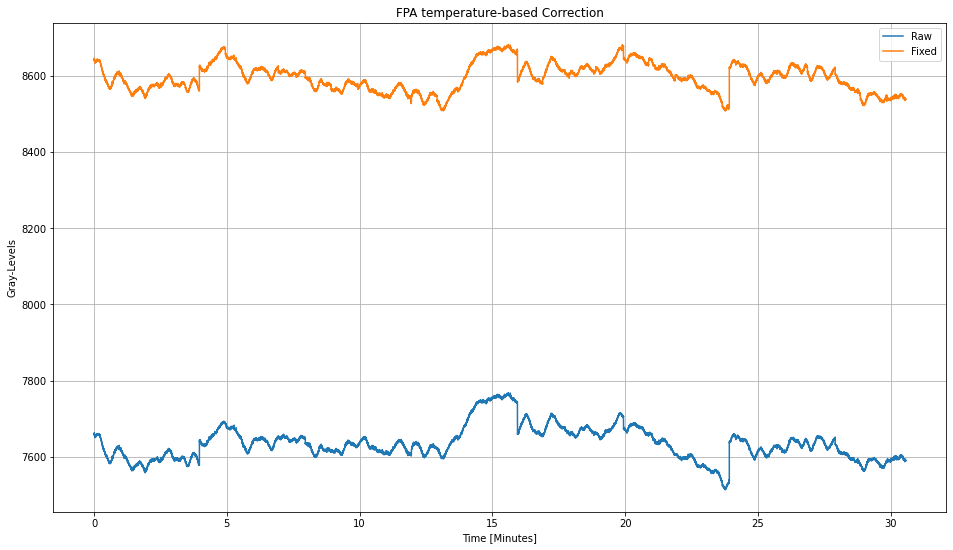

In [9]:
gl_fix = lambda T: (T-35) * lr.coef_.squeeze()
plt.figure(figsize=(16, 9))
x = np.arange(len(gl)) / 3600
plt.plot(x, gl, label="Raw")
plt.plot(x, gl - gl_fix(fpa.values), label="Fixed")
plt.legend()
plt.title("FPA temperature-based Correction")
plt.xlabel("Time [Minutes]")
plt.ylabel("Gray-Levels")
plt.grid()
plt.show()
plt.close()


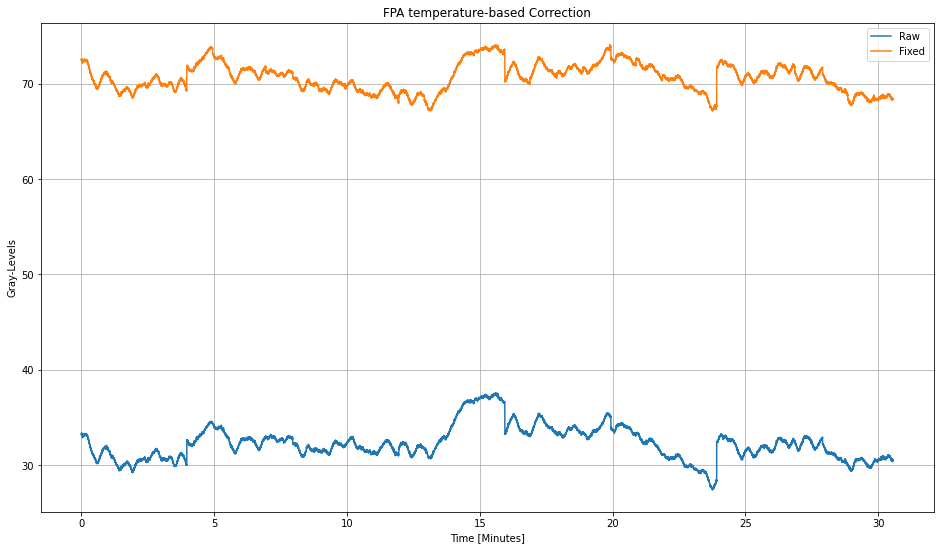

In [11]:
gl_fix = lambda T: (T-35) * lr.coef_.squeeze()
plt.figure(figsize=(16, 9))
x = np.arange(len(gl)) / 3600
plt.plot(x, 0.04*gl-273.15, label="Raw")
plt.plot(x, 0.04*(gl - gl_fix(fpa.values)) - 273.15, label="Fixed")
plt.legend()
plt.title("FPA temperature-based Correction")
plt.xlabel("Time [Minutes]")
plt.ylabel("Gray-Levels")
plt.grid()
plt.show()
plt.close()

Correcting based on the regression seems to reduce the nuisance dynamic range from 500 to 300 grey-levels.

To get a better regression model/corrections - we probably need to collect data over a larger span of FPA temperatures.